# Concepts attribution for fCRP-EfficientNet

In [1]:
!nvidia-smi

Tue Jun  3 07:06:16 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:81:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |      1MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from utils import read_json

import math
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.spatial import distance

In [4]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

from crp.image import imgify

# 1. Reentrenamiento a secas

In [10]:
json = read_json('config_prostate.json')
model_chkpt = 'saved/models/fCRP-prostate/0602_213033/model_best.pth'

In [11]:
config = ConfigParser(json, resume=model_chkpt)

In [12]:
checkpoint = torch.load(config.resume, weights_only = False)
state_dict = checkpoint['state_dict']

In [13]:
model = config.init_obj('arch', module_arch)

model.load_state_dict(state_dict)
model.eval()

data_loader = config.init_obj('data_loader_test', module_data)
sample_subset = [data_loader.dataset[i] for i in {0, 20, 40, 50}]

In [14]:
sample_subset[0][0].shape

torch.Size([3, 374, 374])

In [15]:
sample, idx = sample_subset[0]

In [16]:
model(sample.unsqueeze(0)).argmax()

tensor(0)

In [17]:
def generate_results(model):
	model.eval()
	for (input, label) in sample_subset:
		output = model(input.unsqueeze(0))
		pred_class = output.argmax()
		print(f"Model prediction {pred_class}. GT-Label: {label}")
	model.train()

generate_results(model)

Model prediction 0. GT-Label: 0
Model prediction 2. GT-Label: 2
Model prediction 1. GT-Label: 1
Model prediction 2. GT-Label: 2


In [18]:
from crp.helper import get_layer_names

conditions = [{"y": 46}]
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

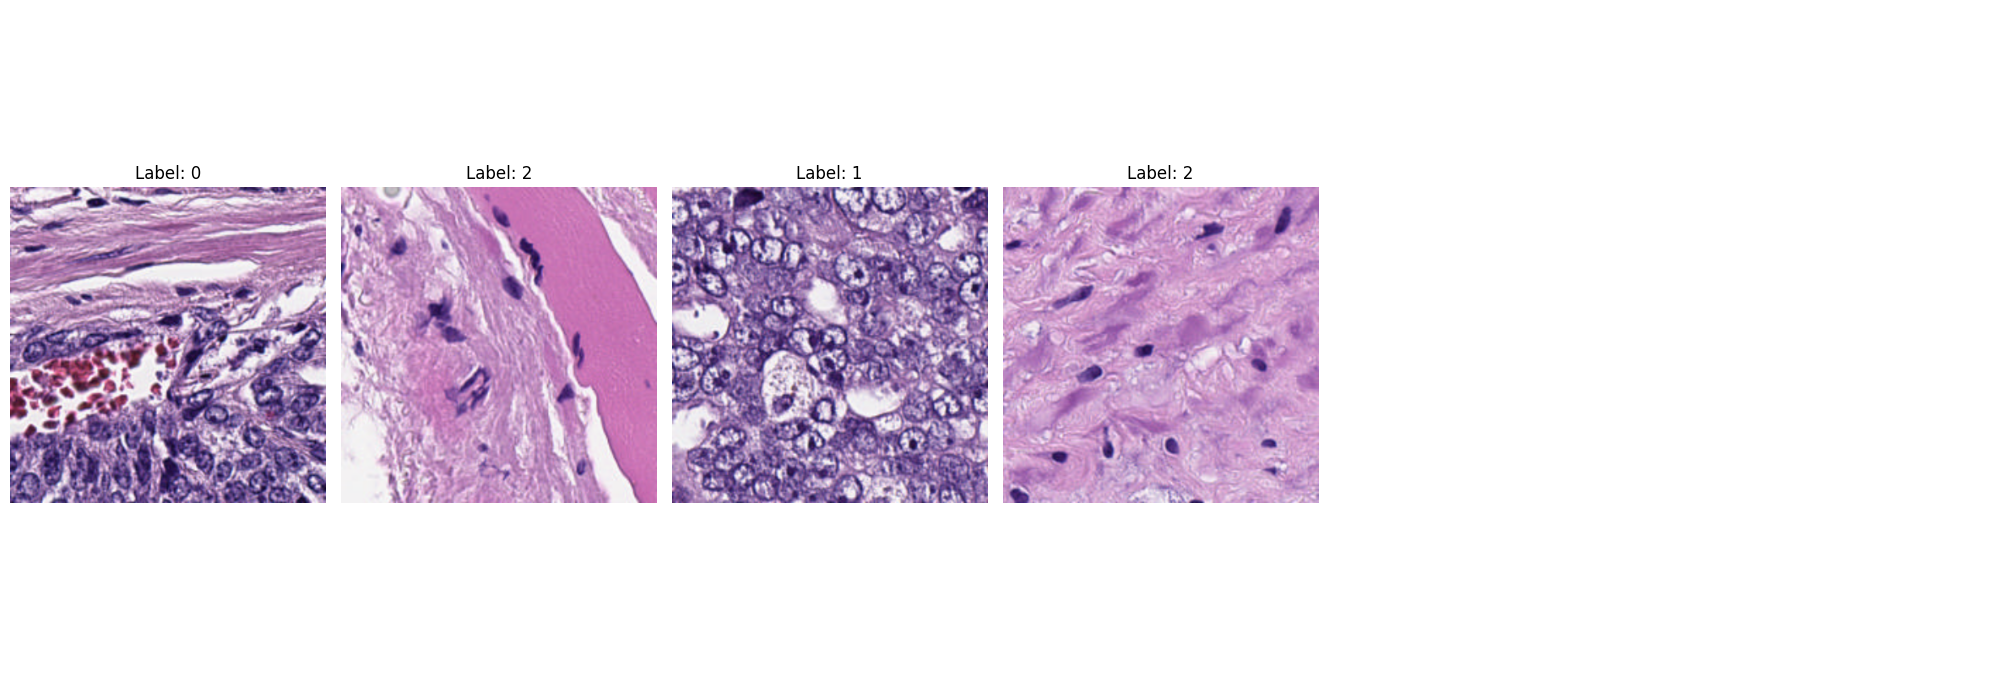

In [19]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image.
    Args:
        tensor (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list or tuple): Mean values for each channel.
        std (list or tuple): Standard deviation values for each channel.
    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean).view(tensor.shape[0], 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std).view(tensor.shape[0], 1, 1)

    return tensor * std + mean

def visualize_batch_denormalized(list_tensors, mean, std, titles=None, num_cols=4, figsize=None):
    """
    Visualizes a batch of DENORMALIZED image tensors in a grid.
    Args:
        list_tensors (torch.Tensor): List of image tensors (C, H, W), ASSUMED NORMALIZED.
        mean (list or tuple): Mean values used for normalization.
        std (list or tuple): Standard deviation values used for normalization.
        titles (list of str, optional): List of titles for each image.
        num_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size (width, height).
    """
    batch_size = len(list_tensors)
    num_rows = math.ceil(batch_size / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(list_tensors):
        ax = axes[i]
        
        # Denormalize the image tensor
        denormalized_img_tensor = denormalize(img_tensor, mean, std)

        # Convert to numpy and handle channel order
        if denormalized_img_tensor.shape[0] == 1: # Grayscale
            img_np = denormalized_img_tensor.squeeze().cpu().numpy()
        else: # RGB
            img_np = denormalized_img_tensor.permute(1, 2, 0).cpu().numpy()
            
        # Clip values to [0, 1] in case of floating point inaccuracies
        img_np = np.clip(img_np, 0, 1)
            
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title("sample")
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Label: {label}")
        
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch_denormalized(sample_subset, data_loader.dataset.normalize_mean, data_loader.dataset.normalize_std, num_cols=6, figsize=(20, 7))

In [21]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

cc = ChannelConcept()

attr = attribution(input_zennit, conditions, composite, record_layer=layer_names)
rel_c = cc.attribute(attr.relevances['features.8.0'], abs_norm=True)

In [22]:
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([ 613, 1244,  525,  699,  774,  414,  409,  825, 1332,  182, 1054,  569,
          668,  218,  450,  580,  777,  557,  998, 1032]),
 tensor([0.8688, 0.8183, 0.7880, 0.7476, 0.6264, 0.5809, 0.5708, 0.5455, 0.5152,
         0.4950, 0.4950, 0.4710, 0.4647, 0.4597, 0.4571, 0.4546, 0.4142, 0.3890,
         0.3864, 0.3738]))

In [24]:
conditions = [{'features.8.0': [id], 'y': [3]} for id in concept_ids]
heatmap, _, _, _ = attribution(input_zennit, conditions, composite)

In [26]:
heatmap

tensor([[[ 1.9613e-07,  2.5258e-07,  5.6449e-08,  ...,  5.8681e-07,
           2.5272e-07,  2.5272e-07],
         [ 2.6780e-07,  3.6572e-07,  9.7926e-08,  ...,  8.3144e-07,
           3.4533e-07,  3.4533e-07],
         [ 7.1666e-08,  1.1314e-07,  4.1477e-08,  ...,  2.4463e-07,
           9.2611e-08,  9.2611e-08],
         ...,
         [ 5.7091e-07,  1.0816e-06,  5.1072e-07,  ...,  1.4581e-07,
           1.1982e-07,  1.1982e-07],
         [ 2.9883e-07,  5.9618e-07,  2.9736e-07,  ...,  8.5709e-08,
           6.7938e-08,  6.7938e-08],
         [ 2.9883e-07,  5.9618e-07,  2.9736e-07,  ...,  8.5709e-08,
           6.7938e-08,  6.7938e-08]],

        [[ 1.0176e-07,  1.3277e-07,  3.1008e-08,  ...,  2.8335e-07,
           1.2170e-07,  1.2170e-07],
         [ 1.4533e-07,  2.0188e-07,  5.6546e-08,  ...,  4.0324e-07,
           1.6665e-07,  1.6665e-07],
         [ 4.3573e-08,  6.9111e-08,  2.5537e-08,  ...,  1.1989e-07,
           4.4957e-08,  4.4957e-08],
         ...,
         [ 2.7938e-07,  5

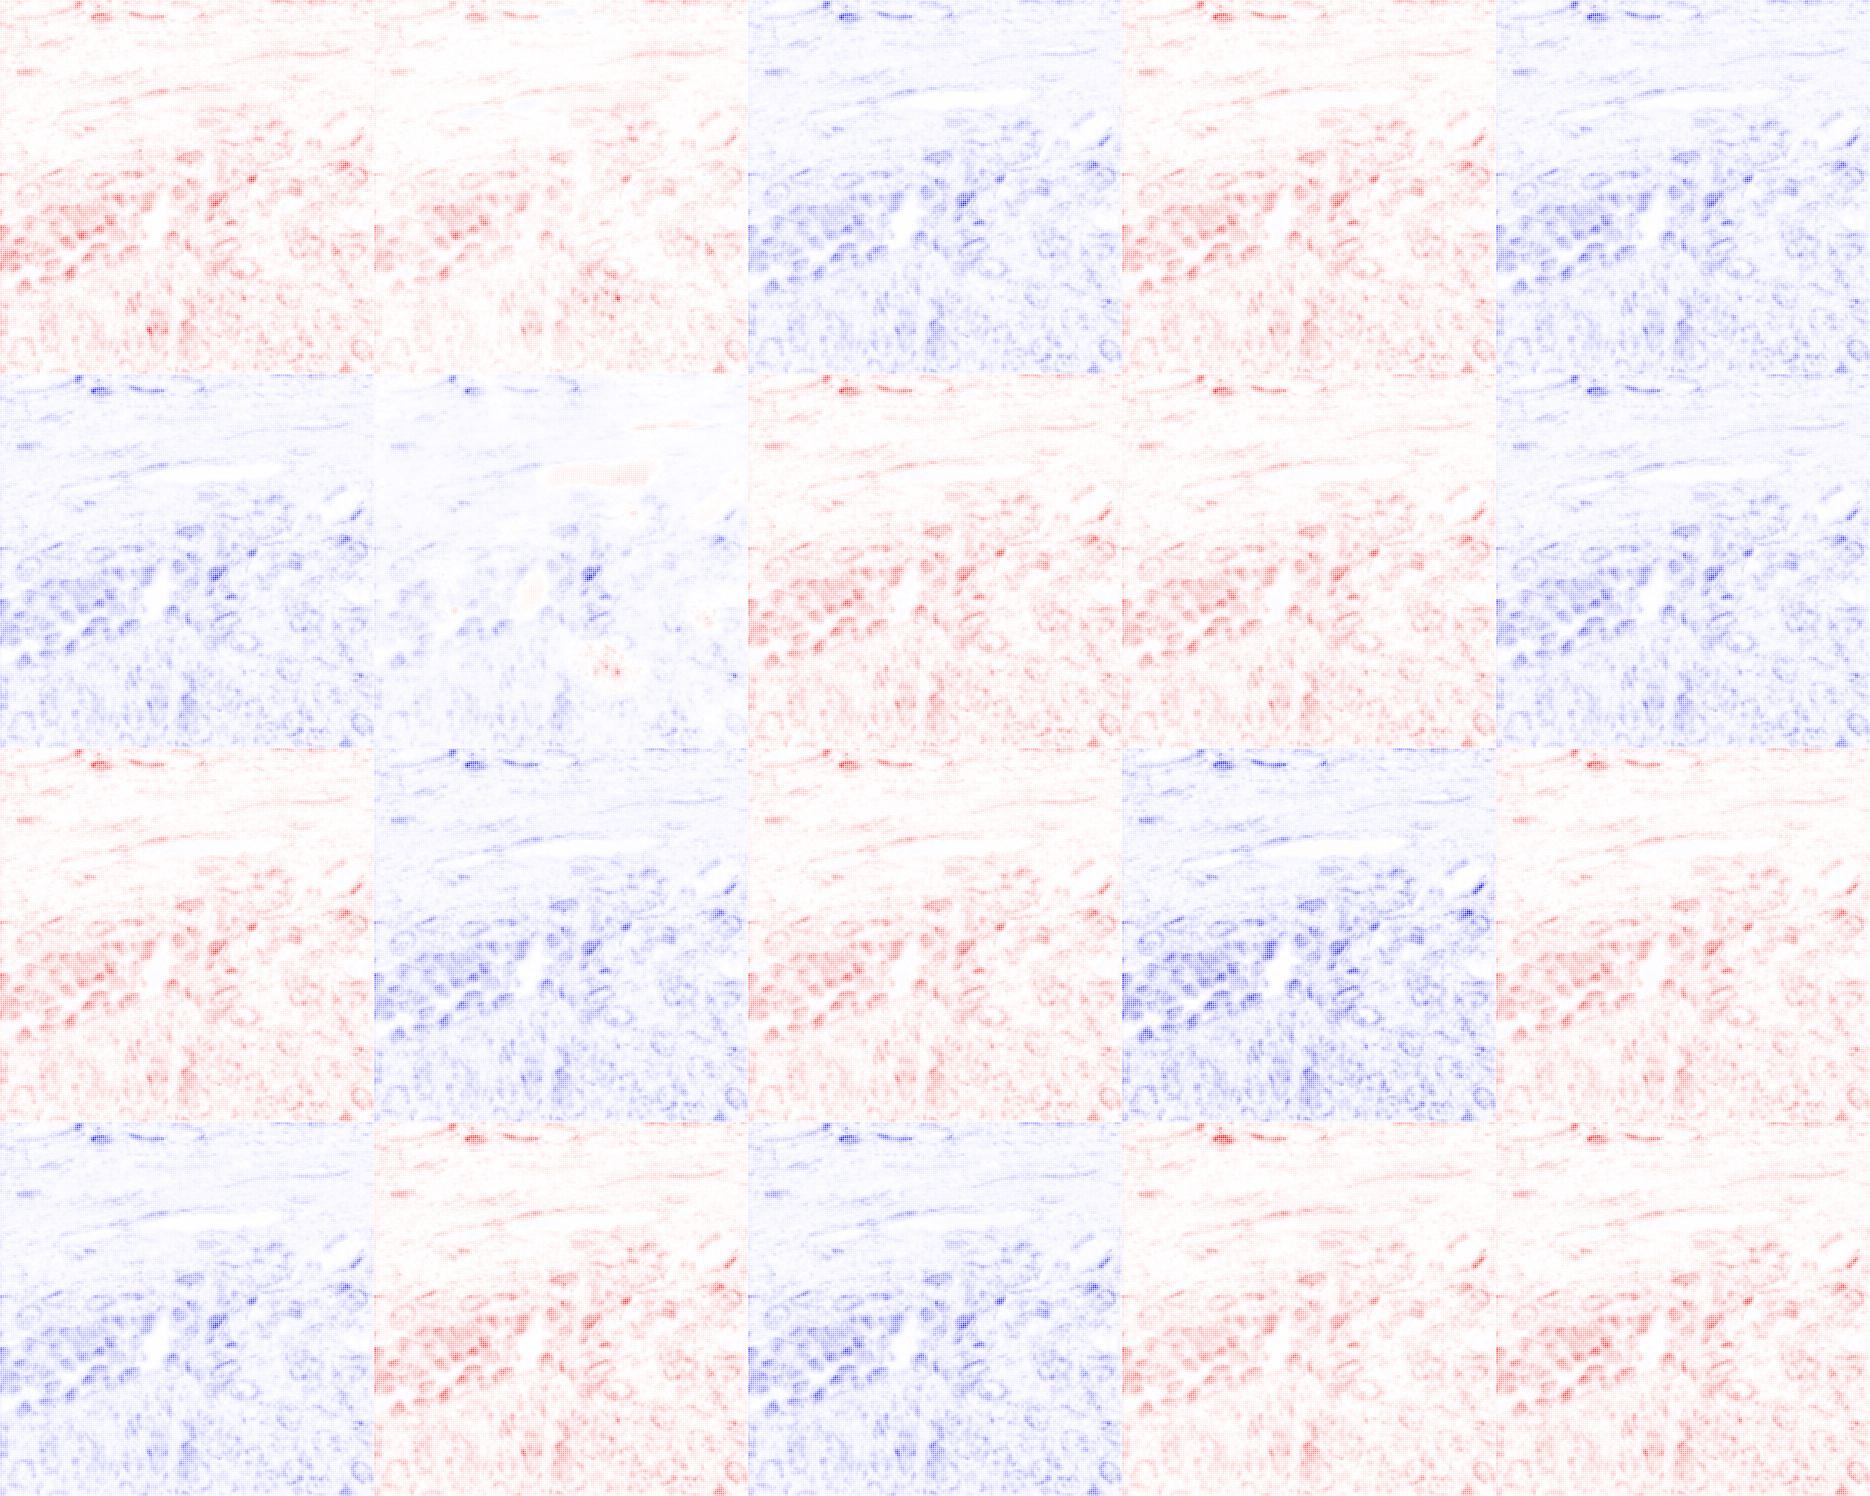

In [27]:
imgify(heatmap, symmetric=True, grid=(4,5))

In [ ]:
heatmap[0] - heatmap[1]

tensor([[ 5.9989,  7.5138,  1.5149,  ..., 19.3094, 13.0773, 13.0773],
        [ 8.6851, 11.6007,  2.9156,  ..., 28.0524, 19.5232, 19.5232],
        [ 2.6862,  4.0869,  1.4007,  ...,  8.7431,  6.4459,  6.4459],
        ...,
        [ 8.1108,  9.9349,  1.8240,  ...,  6.4914,  3.3951,  3.3951],
        [ 3.6506,  4.5444,  0.8938,  ...,  3.8644,  1.9154,  1.9154],
        [ 3.6506,  4.5444,  0.8938,  ...,  3.8644,  1.9154,  1.9154]])

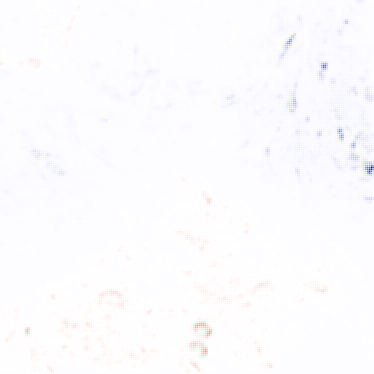

In [ ]:
conditions = [{'model.features.8.0': [20], 'y': [3]}]
heatmap_rand, _, _, _ = attribution(input_zennit, conditions, composite)
imgify(heatmap_rand, symmetric=True)

In [ ]:
def find_ess_heatmaps(heatmaps, tol=0.1):
	unique = []
	neg_tol = 1 - tol

	for hm in heatmaps:
		found = False
		for elem in unique:
			pearson = scipy.stats.pearsonr(elem.flatten(), hm.flatten())[0]

			if np.abs(pearson) > neg_tol:
				found = True
				break

		if not found:
			unique.append(hm)

	final_heatmap = torch.stack(unique)
	return final_heatmap

unique_heatmap = find_ess_heatmaps(heatmap)

In [ ]:
unique_heatmap.shape

torch.Size([2, 374, 374])

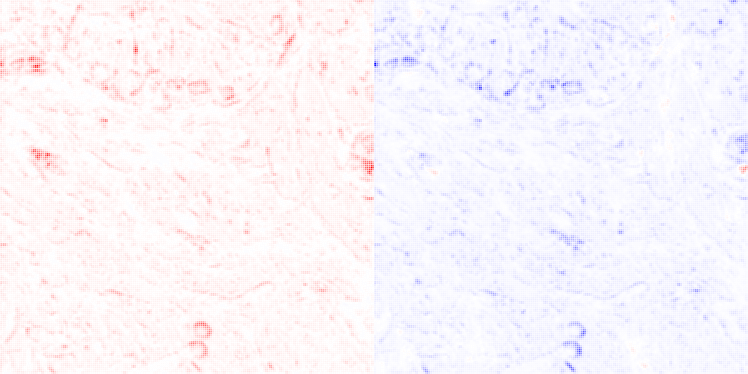

In [ ]:
imgify(unique_heatmap, symmetric=True, grid=(1,2))

In [ ]:
input_zennit.shape

torch.Size([1, 3, 374, 374])

In [ ]:
torch.stack([
	torch.Tensor([1,2,3]),
torch.Tensor([1,2,3]),
])

tensor([[1., 2., 3.],
        [1., 2., 3.]])

# 2. Reentrenmaienot con mayor loss

In [28]:
json_xmi = read_json('config_prostate_xmi.json')
model_chkpt_xmi = 'saved/models/xMI-Efficient/0527_132703/model_best.pth'

In [29]:
config_xmi = ConfigParser(json_xmi, resume=model_chkpt_xmi)
checkpoint_xmi = torch.load(config_xmi.resume, weights_only = False)
state_dict_xmi = checkpoint_xmi['state_dict']

In [30]:
model_xmi = config_xmi.init_obj('arch', module_arch)

model_xmi.load_state_dict(state_dict_xmi)
model_xmi.eval()

xMIEfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActi

In [31]:
get_layer_names(model_xmi, [torch.nn.Conv2d, torch.nn.Linear])

['features.0.0',
 'features.1.0.block.0.0',
 'features.1.0.block.1.fc1',
 'features.1.0.block.1.fc2',
 'features.1.0.block.2.0',
 'features.1.1.block.0.0',
 'features.1.1.block.1.fc1',
 'features.1.1.block.1.fc2',
 'features.1.1.block.2.0',
 'features.2.0.block.0.0',
 'features.2.0.block.1.0',
 'features.2.0.block.2.fc1',
 'features.2.0.block.2.fc2',
 'features.2.0.block.3.0',
 'features.2.1.block.0.0',
 'features.2.1.block.1.0',
 'features.2.1.block.2.fc1',
 'features.2.1.block.2.fc2',
 'features.2.1.block.3.0',
 'features.2.2.block.0.0',
 'features.2.2.block.1.0',
 'features.2.2.block.2.fc1',
 'features.2.2.block.2.fc2',
 'features.2.2.block.3.0',
 'features.3.0.block.0.0',
 'features.3.0.block.1.0',
 'features.3.0.block.2.fc1',
 'features.3.0.block.2.fc2',
 'features.3.0.block.3.0',
 'features.3.1.block.0.0',
 'features.3.1.block.1.0',
 'features.3.1.block.2.fc1',
 'features.3.1.block.2.fc2',
 'features.3.1.block.3.0',
 'features.3.2.block.0.0',
 'features.3.2.block.1.0',
 'features

In [32]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
layer_names_xmi = get_layer_names(model_xmi, [torch.nn.Conv2d, torch.nn.Linear])
attribution_xmi = CondAttribution(model_xmi, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

attr = attribution_xmi(input_zennit, conditions, composite, record_layer=layer_names_xmi)
rel_c = cc.attribute(attr.relevances['mi_layer.1'], abs_norm=True)
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([14, 21, 15, 36, 47, 11, 48,  3,  0, 17, 33,  9, 49, 18, 26, 16, 23, 32,
         34, 44]),
 tensor([ 6.2233,  5.3035,  3.4434,  3.4143,  3.3514,  2.5930,  1.7139,  1.7129,
          1.0639,  1.0276,  0.8160,  0.6203,  0.5481,  0.3180,  0.2140, -0.0523,
         -0.1182, -0.2115, -0.5077, -0.6715]))

In [33]:
generate_results(model_xmi)

Model prediction 0. GT-Label: 0
Model prediction 2. GT-Label: 2
Model prediction 1. GT-Label: 1
Model prediction 2. GT-Label: 2


In [34]:
conditions = [{'mi_layer.1': [id], 'y': [3]} for id in concept_ids]
heatmap_xmi, _, _, _ = attribution_xmi(input_zennit, conditions, composite)

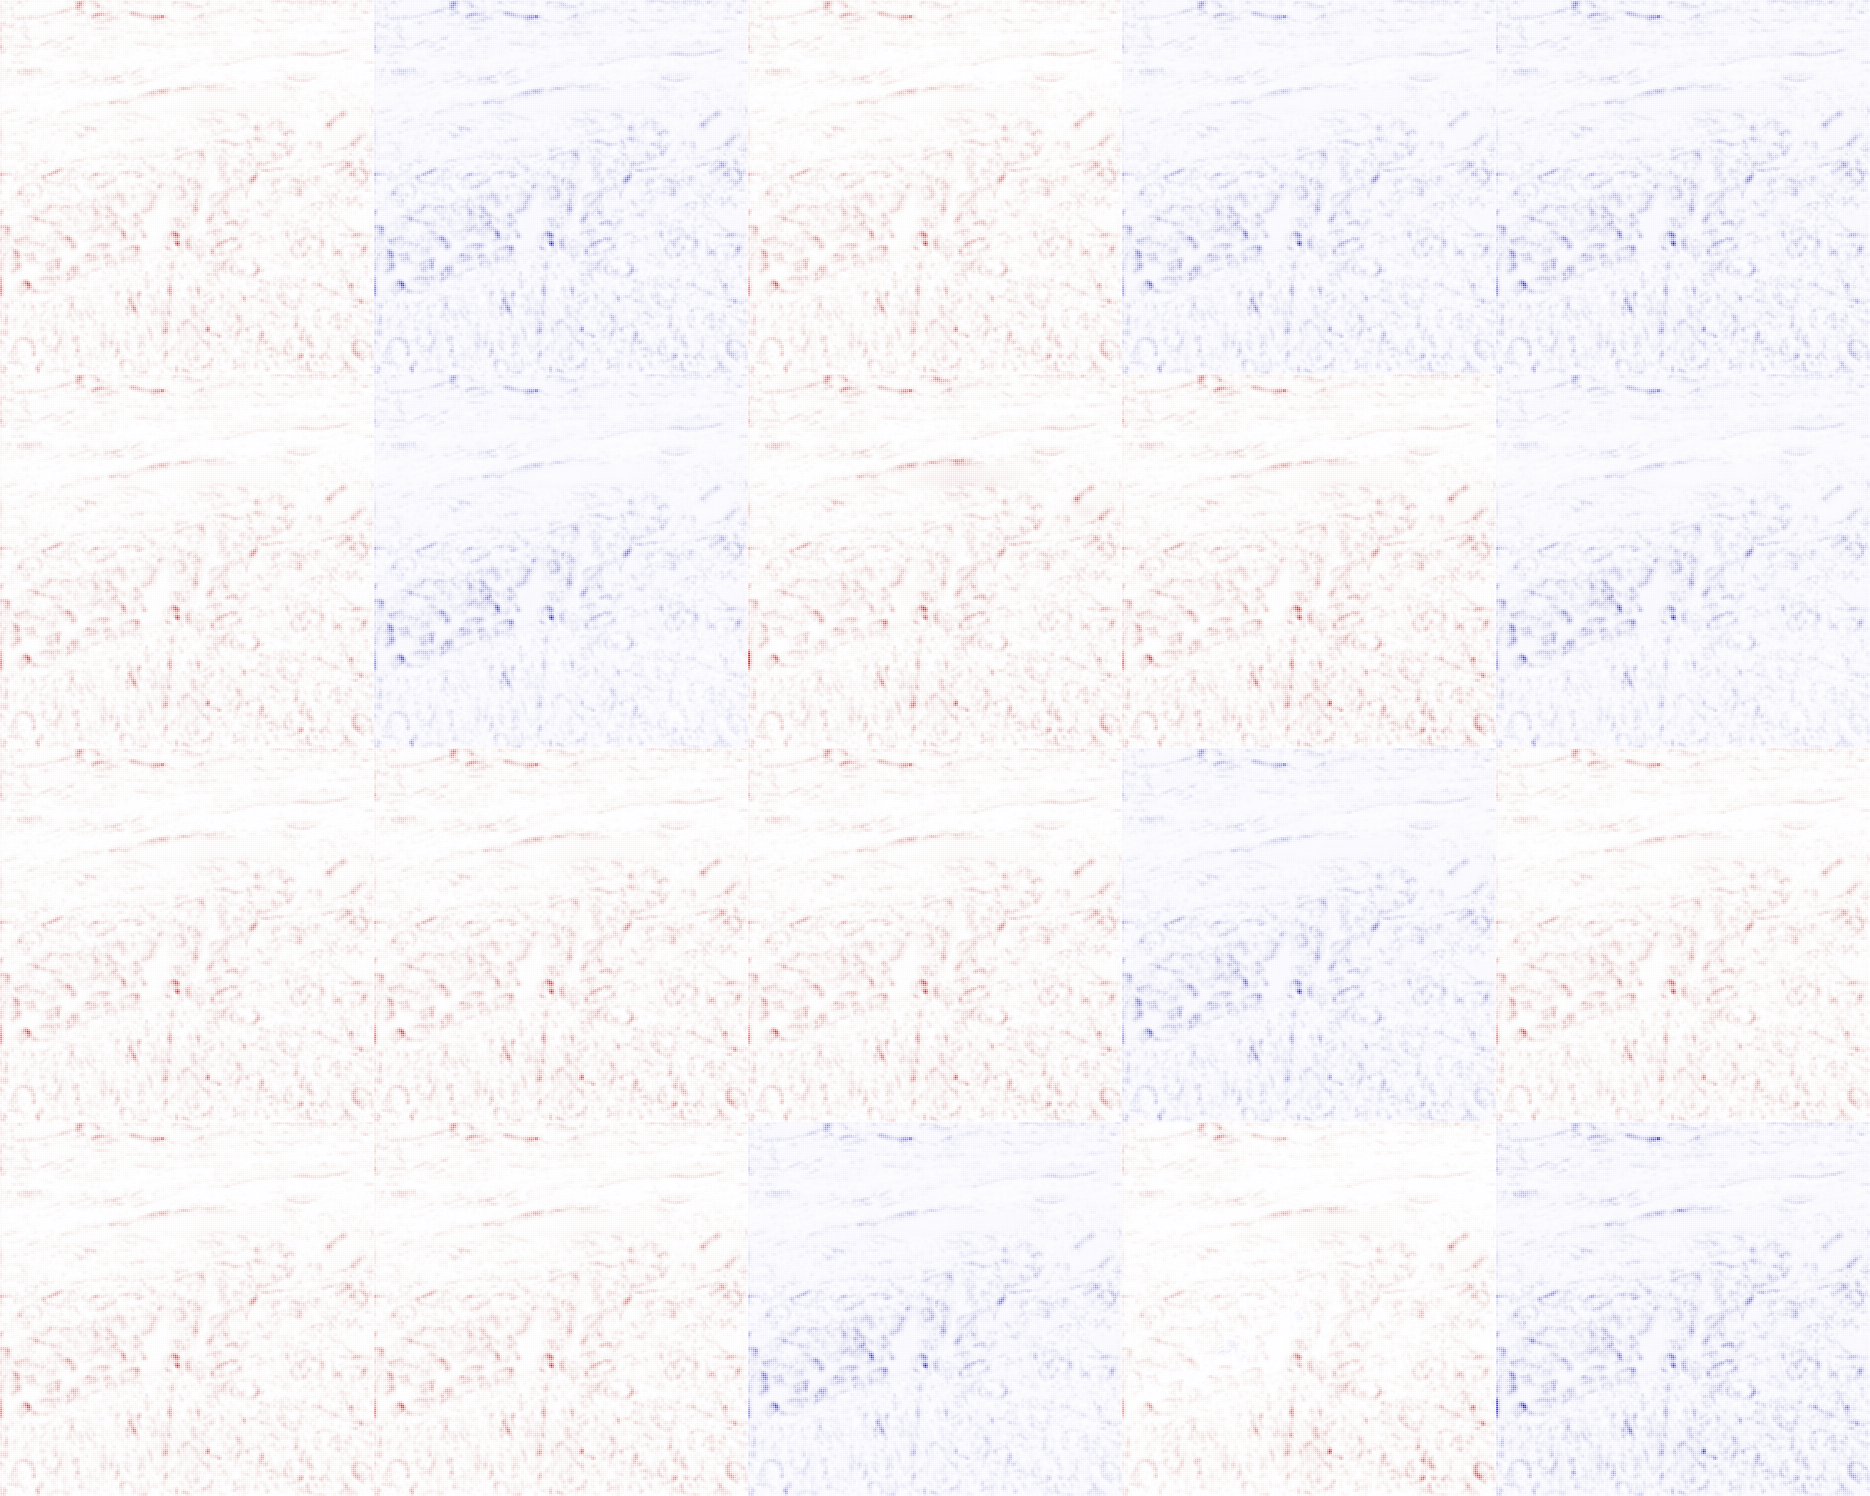

In [35]:
imgify(heatmap_xmi, symmetric=True, grid=(4,5))

In [36]:
model_xmi.train()
model_xmi(sample.unsqueeze(0))

tensor([[-7.5078, -9.5593, -5.0394, -0.0161, -7.5871, -9.8567, -8.4558, -8.4320,
         -7.1044, -8.4180, -5.4228, -6.6493, -8.0855, -7.0969]])

# 3. Reentrenamiento con pesos congelados

In [ ]:
json = read_json('config_prostate.json')
model_chkpt = 'saved/models/fCRP-prostate/0602_001536/model_best.pth'

In [ ]:
config = ConfigParser(json, resume=model_chkpt)

In [ ]:
checkpoint = torch.load(config.resume, weights_only = False)
state_dict = checkpoint['state_dict']

In [ ]:
model = config.init_obj('arch', module_arch)

model.load_state_dict(state_dict)
model.eval()

data_loader = config.init_obj('data_loader_test', module_data)
sample_subset = [data_loader.dataset[i] for i in {600, 700, 800, 1000, 1100, 20}]

In [ ]:
sample_subset[0][0].shape

torch.Size([3, 374, 374])

In [ ]:
sample, idx = sample_subset[0]

In [ ]:
model(sample.unsqueeze(0)).argmax()

tensor(3)

In [ ]:
def generate_results(model):
	model.eval()
	for (input, label) in sample_subset:
		output = model(input.unsqueeze(0))
		pred_class = output.argmax()
		print(f"Model prediction {pred_class}. GT-Label: {label}")
	model.train()

generate_results(model)

Model prediction 3. GT-Label: 3
Model prediction 6. GT-Label: 6
Model prediction 10. GT-Label: 10
Model prediction 0. GT-Label: 0
Model prediction 3. GT-Label: 3
Model prediction 3. GT-Label: 3


In [ ]:
from crp.helper import get_layer_names

conditions = [{"y": 46}]
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

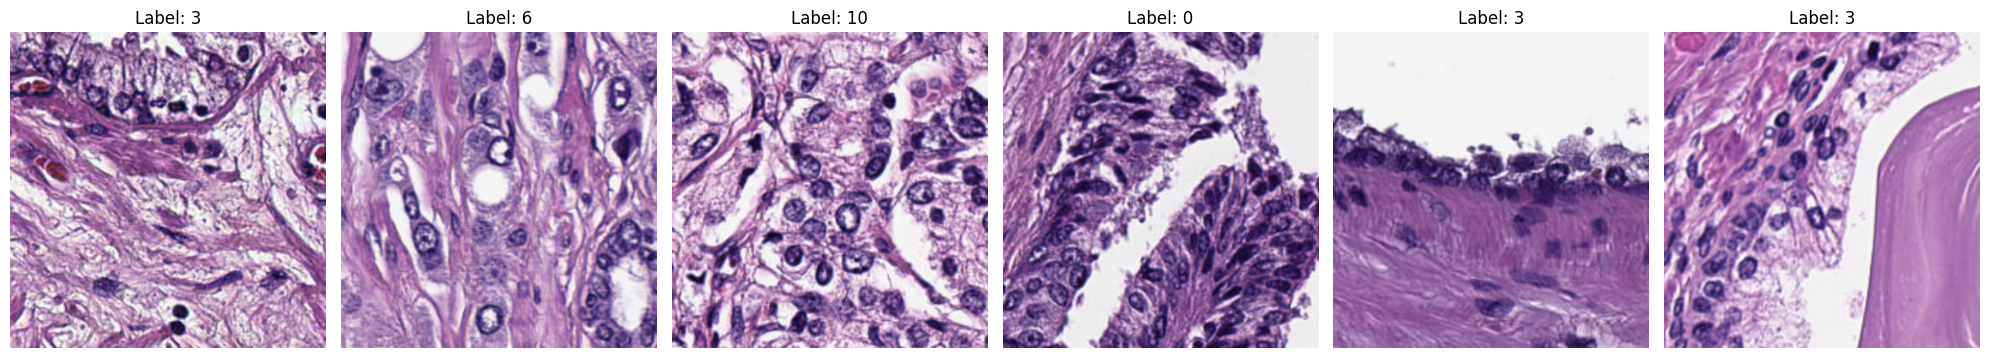

In [ ]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image.
    Args:
        tensor (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list or tuple): Mean values for each channel.
        std (list or tuple): Standard deviation values for each channel.
    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean).view(tensor.shape[0], 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std).view(tensor.shape[0], 1, 1)

    return tensor * std + mean

def visualize_batch_denormalized(list_tensors, mean, std, titles=None, num_cols=4, figsize=None):
    """
    Visualizes a batch of DENORMALIZED image tensors in a grid.
    Args:
        list_tensors (torch.Tensor): List of image tensors (C, H, W), ASSUMED NORMALIZED.
        mean (list or tuple): Mean values used for normalization.
        std (list or tuple): Standard deviation values used for normalization.
        titles (list of str, optional): List of titles for each image.
        num_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size (width, height).
    """
    batch_size = len(list_tensors)
    num_rows = math.ceil(batch_size / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(list_tensors):
        ax = axes[i]
        
        # Denormalize the image tensor
        denormalized_img_tensor = denormalize(img_tensor, mean, std)

        # Convert to numpy and handle channel order
        if denormalized_img_tensor.shape[0] == 1: # Grayscale
            img_np = denormalized_img_tensor.squeeze().cpu().numpy()
        else: # RGB
            img_np = denormalized_img_tensor.permute(1, 2, 0).cpu().numpy()
            
        # Clip values to [0, 1] in case of floating point inaccuracies
        img_np = np.clip(img_np, 0, 1)
            
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title("sample")
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Label: {label}")
        
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch_denormalized(sample_subset, data_loader.dataset.normalize_mean, data_loader.dataset.normalize_std, num_cols=6, figsize=(20, 7))

In [ ]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

cc = ChannelConcept()

attr = attribution(input_zennit, conditions, composite, record_layer=layer_names)
rel_c = cc.attribute(attr.relevances['model.features.8.0'], abs_norm=True)

In [ ]:
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([1266,  478,  259,   88,  911, 1097,  517,  532,  684, 1199, 1219,  833,
          715,  173, 1321,   74,  218,  916, 1111,  436]),
 tensor([0.9713, 0.9179, 0.8592, 0.7898, 0.7445, 0.7151, 0.5764, 0.5497, 0.5390,
         0.4910, 0.4896, 0.4803, 0.4483, 0.4430, 0.4376, 0.4209, 0.4163, 0.3842,
         0.3762, 0.3736]))

In [ ]:
conditions = [{'model.features.8.0': [id], 'y': [3]} for id in concept_ids]
heatmap, _, _, _ = attribution(input_zennit, conditions, composite)

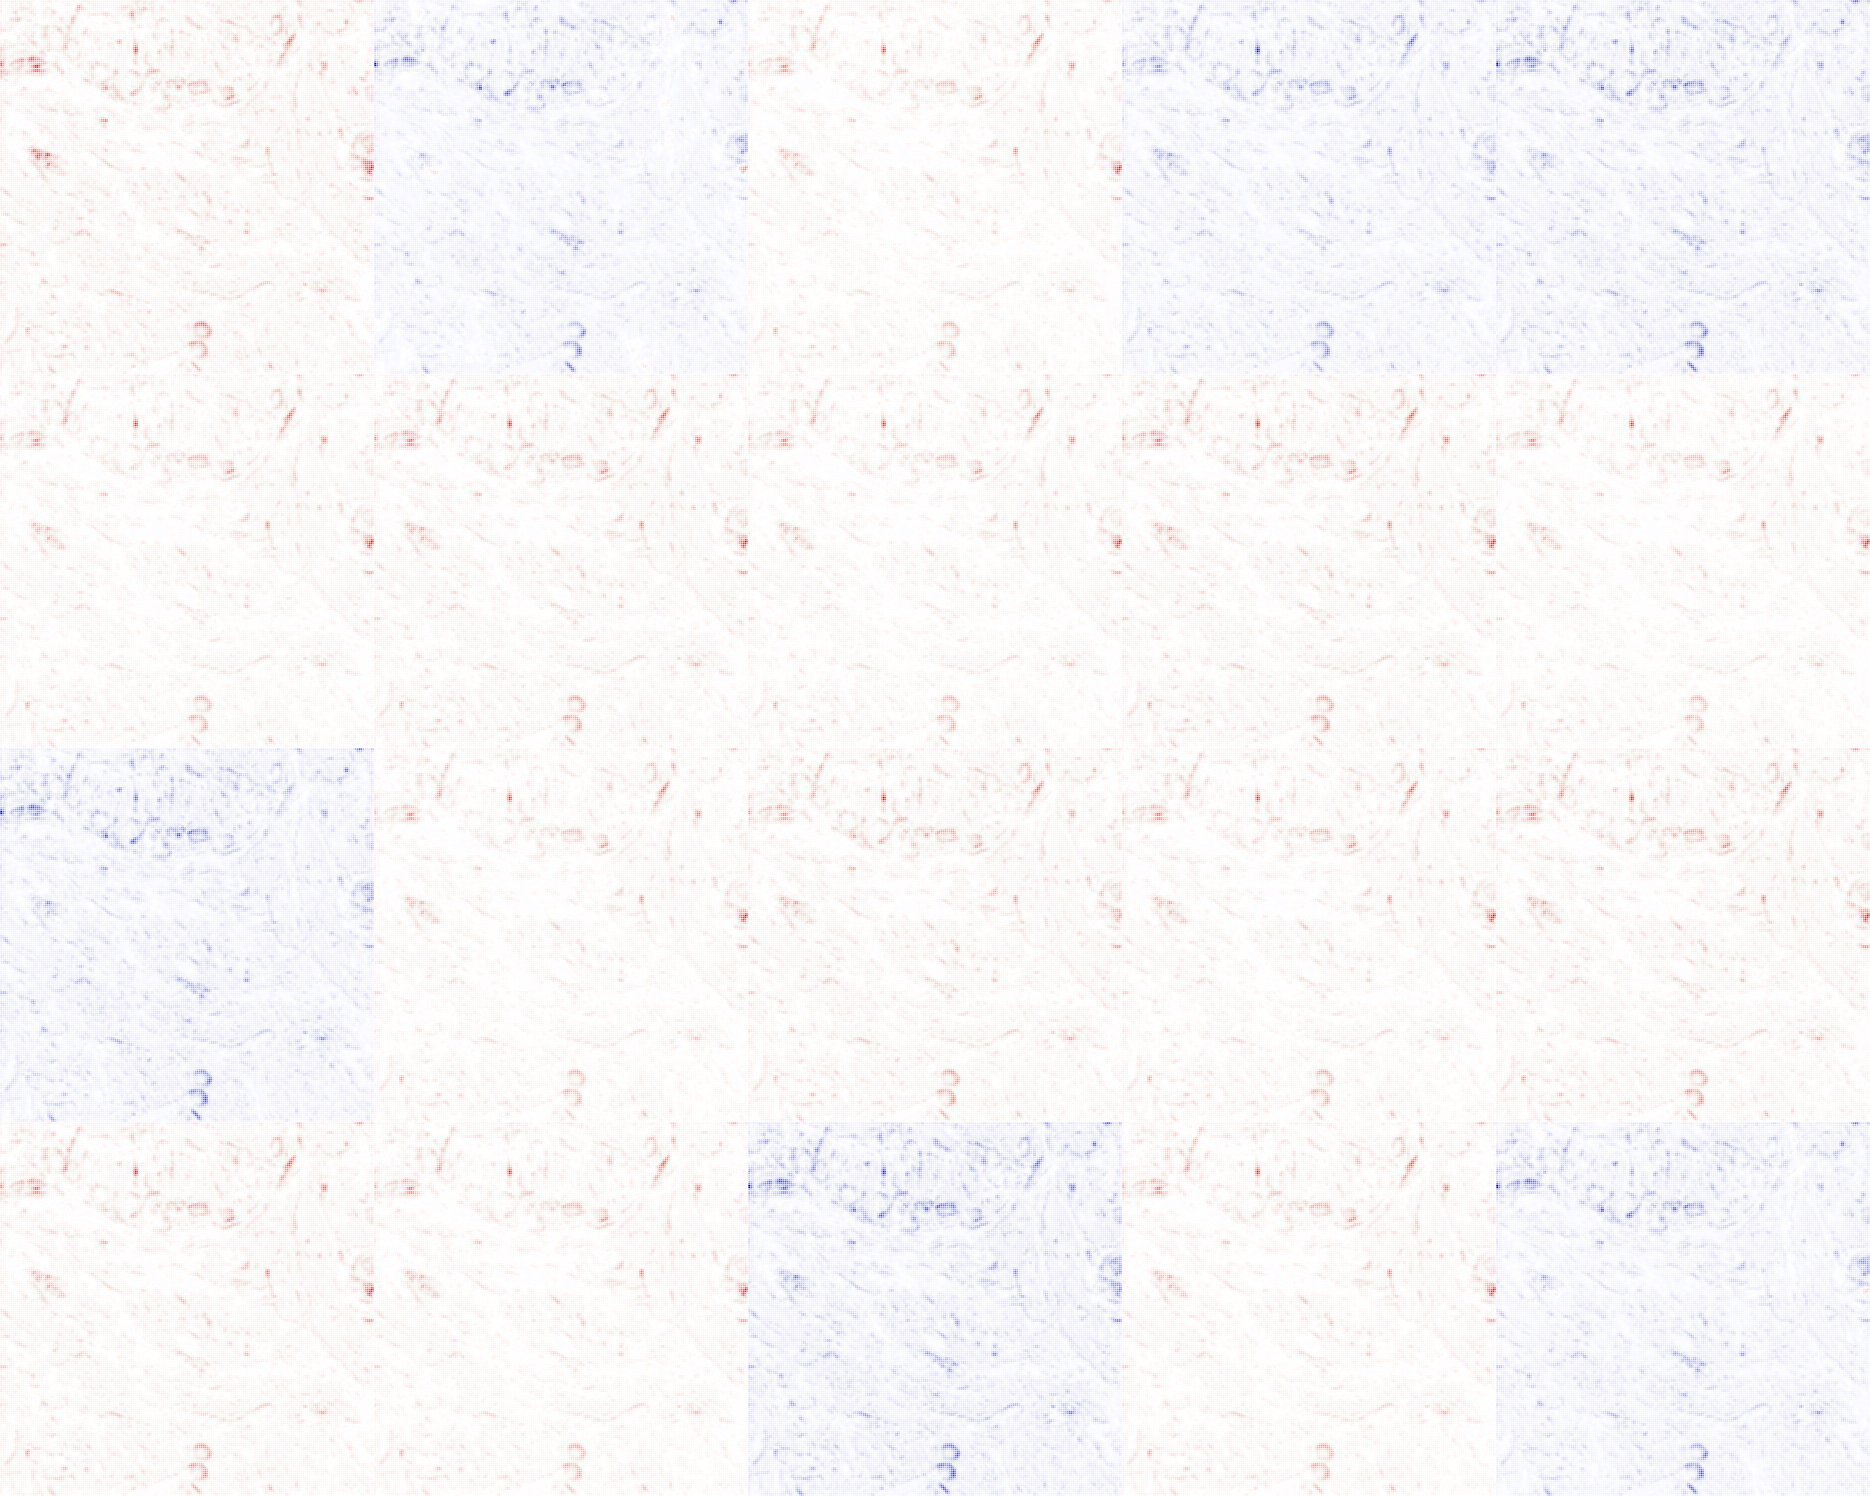

In [ ]:
imgify(heatmap, symmetric=True, grid=(4,5))

In [ ]:
heatmap[0] - heatmap[1]

tensor([[ 5.9989,  7.5138,  1.5149,  ..., 19.3094, 13.0773, 13.0773],
        [ 8.6851, 11.6007,  2.9156,  ..., 28.0524, 19.5232, 19.5232],
        [ 2.6862,  4.0869,  1.4007,  ...,  8.7431,  6.4459,  6.4459],
        ...,
        [ 8.1108,  9.9349,  1.8240,  ...,  6.4914,  3.3951,  3.3951],
        [ 3.6506,  4.5444,  0.8938,  ...,  3.8644,  1.9154,  1.9154],
        [ 3.6506,  4.5444,  0.8938,  ...,  3.8644,  1.9154,  1.9154]])

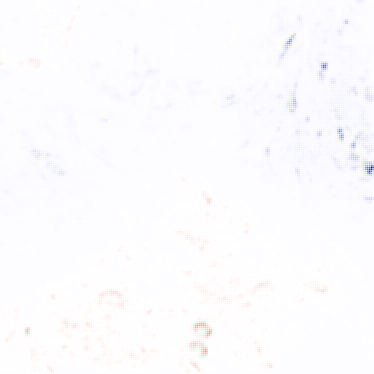

In [ ]:
conditions = [{'model.features.8.0': [20], 'y': [3]}]
heatmap_rand, _, _, _ = attribution(input_zennit, conditions, composite)
imgify(heatmap_rand, symmetric=True)

In [ ]:
def find_ess_heatmaps(heatmaps, tol=0.1):
	unique = []
	neg_tol = 1 - tol

	for hm in heatmaps:
		found = False
		for elem in unique:
			pearson = scipy.stats.pearsonr(elem.flatten(), hm.flatten())[0]

			if np.abs(pearson) > neg_tol:
				found = True
				break

		if not found:
			unique.append(hm)

	final_heatmap = torch.stack(unique)
	return final_heatmap

unique_heatmap = find_ess_heatmaps(heatmap)

In [ ]:
unique_heatmap.shape

torch.Size([2, 374, 374])

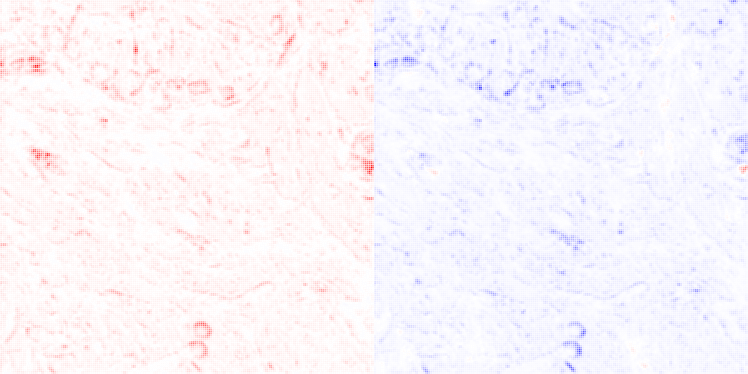

In [ ]:
imgify(unique_heatmap, symmetric=True, grid=(1,2))

In [ ]:
input_zennit.shape

torch.Size([1, 3, 374, 374])

In [ ]:
torch.stack([
	torch.Tensor([1,2,3]),
torch.Tensor([1,2,3]),
])

tensor([[1., 2., 3.],
        [1., 2., 3.]])